In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import h5py as h5
from yt.utilities import cosmology as co

In [2]:
from matplotlib import rc
rc('font', size=18)

In [3]:
cosmo = co.Cosmology(hubble_constant=0.71, omega_matter=0.266, omega_lambda=0.734)

# Read file with center and J_LW(z)

In [4]:
#infile = "jlw-region.dat"
#infile = 'MM-position.dat'
infile = 'dcbh-106608.dat'
fp = open(infile, "r")
center = {}
redshift = {}
time = {}
J_from_file = {}
for line in fp.readlines():
    if line.startswith('#'): continue
    parts = line.split()
    ds = parts[1]
    center[ds] = np.array([float(p) for p in parts[3:6]])
    redshift[ds] = float(parts[0])
    J_from_file[ds] = float(parts[6])
    time[ds] = cosmo.t_from_z(redshift[ds]).to('Myr').v
fp.close()

# Load star data
Sort everything by particle ID for easier searching

In [6]:
stardir = 'star-data'
sdata = {}
first_time = True
attributes = dict(top=['time_unit', 'boxsize'], output=['current_redshift', 'current_time'])
for fn in sorted(glob.glob("%s/*.h5" % (stardir))):
    ds = fn.split("/")[-1].split("-stars")[0]
    sdata[ds] = {}
    fp = h5.File(fn, 'r')
    if first_time:
        for attr in attributes['top']:
            sdata[attr] = fp.attrs.get(attr)
        first_time = False
    for attr in attributes['output']:
        sdata[ds][attr] = fp.attrs.get(attr)
    for k in fp.keys():
        sdata[ds][k] = fp[k][:]
    fp.close()
    
for k,dd in sdata.items():
    if k in attributes['top']: continue
    idsort = np.argsort(dd['particle_index'])
    for f in dd.keys():
        if f in attributes['output']: continue
        dd[f] = dd[f][idsort]
    # Correct Pop III masses for SN explosions (1e-20 factor)
    SN3 = (dd['particle_mass'] < 1e-10) & (dd['type'] == 3)
    dd['particle_mass'][SN3] *= 1e20

In [7]:
# If time_unit didn't exist in data file, we have to manually grab it from the parameter file
if sdata['time_unit'] == None:
    sdata['time_unit'] = 6.5927815e14 / 3.1557e13  # Myr

# Function to find adjacent outputs and interpolation factor (in time)

In [8]:
def find_adj_ds(z, allz):
    nz = len(redshift.keys())
    za = np.zeros(nz)
    ds = []
    _ds = []
    for i,k in enumerate(redshift.keys()):
        za[i] = allz[k]
        _ds.append(k)
    zsort = np.argsort(za)
    za = za[zsort]
    for zs in zsort:
        ds.append(_ds[zs])
    iz = np.searchsorted(za, z)
    factor = 0.0
    dt = 0.0  # Myr
    if iz == 0:
        ds0 = ds[iz]
        ds1 = None
    elif iz == nz:
        ds0 = None
        ds1 = ds[iz-1]
    else:
        ds1 = ds[iz-1]
        ds0 = ds[iz]
        # Convert redshift to time (not normalized since we're dealing with fractional values)
        # Assumes an EdS universe
        t = (z+1)**(-2./3)
        t0 = (za[iz-1]+1)**(-2./3)
        t1 = (za[iz]+1)**(-2./3)
        factor = (t - t0) / (t1 - t0)
    return ds0, ds1, factor

In [9]:
def p3life(mass):
    # Schaerer (2002)
    # Input: solar masses
    # Output: Lifetime in Myr
    x = np.log10(mass)
    return 10**(3.785 - 3.759*x + 1.413*x*x - 0.186*x*x*x)

In [10]:
def p3lw(mass):
    # Schaerer (2002)
    # Input: solar masses
    # Output: LW photon luminosity (ph/s)
    x = np.log10(mass)
    return 10**(44.03 + 4.59*x - 0.77*x*x)

# Function to interpolate particle information

In [11]:
def interp_particles(data, ds0, ds1, dt, fint):
    nstars1 = data[ds1]['particle_index'].size
    luminosity_t = np.zeros(nstars1)
    position_t = np.zeros((nstars1,3))
    
    # 
    # Direct interpolation for star particles that exist in both datasets
    #
    exists = np.in1d(data[ds0]['particle_index'], data[ds1]['particle_index'], invert=False)
    #idel = np.where(data[ds0]['particle_index'][deleted])
    match = np.in1d(data[ds1]['particle_index'], data[ds0]['particle_index'][exists])
    dr = data[ds1]['particle_position'][match] - data[ds0]['particle_position'][exists]
    position_t[match] = data[ds0]['particle_position'][exists] + fint*dr
    #print position_t[match]
    
    # Search for massive star particles that are still radiating at the given time
    # Pop III stars
    p3_lifetime = p3life(data[ds1]['particle_mass'])
    p2_lifetime = 20.0
    p3 = (data[ds1]['type'] == 3) & \
        (data[ds1]['age'] - fint*dt < p3_lifetime) & \
        (data[ds1]['age'] - fint*dt > 0)
    # Metal-enriched stars
    p2 = (data[ds1]['type'] == 2) & \
        (data[ds1]['age'] - fint*dt < p2_lifetime) & \
        (data[ds1]['age'] - fint*dt > 0)

    # Calculate ionizing photon luminosity for the living star particles
    specific_LW = 1.288 * 1.12e46  # 1.12e46 ionizing ph/s, 1.288x more LW photons (Schaerer 2003)
    luminosity_t[p3] = p3lw(data[ds1]['particle_mass'][p3])
    luminosity_t[p2] = specific_LW * data[ds1]['particle_mass'][p2]
        
    #
    # For stars that only exist in the latter dataset, we use the velocity to extrapolate 
    # their positions backwards.
    #
    # Discard star particles that haven't been born yet
    new_stars = np.logical_not(match)
    position_t[new_stars] = data[ds1]['particle_position'][new_stars] - \
        fint*(dt/data['time_unit']) * data[ds1]['particle_velocity'][new_stars]
    #print position_t[new_stars]

    # Result dictionary with only radiating particle positions and LW luminosities
    nonz = np.nonzero(luminosity_t)[0]
    idata = dict(position = position_t[nonz], luminosity = luminosity_t[nonz])
    return idata

# Interpolate star particle positions and calculate J_LW at fine-grained redshift values

In [12]:
def scale(val):
    minv = 48.0
    maxv = 52.0
    srange = (1,100)
    ds = (srange[1] - srange[0]) / (maxv - minv)
    return (np.log10(val) - minv) * ds

In [13]:
def plot_stars(idata, i, z):
    fig, ax = plt.subplots(1,1, figsize=(10,8))
    ax.scatter(iparticles['position'][:,0], iparticles['position'][:,1], 
                s=scale(iparticles['luminosity']), marker='o', edgecolors='k', alpha=0.3, c='C0')
    ax.set_title('z = %.2f' % z)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.savefig('stars%4.4d.png' % (i))    

In [14]:
N_to_J = 4.80814e-28  # ph/s/cm^2 -> erg/s/cm^2/Hz/sr

In [15]:
def calc_JLW_at_point(idata, point, cm_boxsize, z):
    if not isinstance(point, np.ndarray):
        point = np.array(point)
    if point.size != 3:
        raise RuntimeError('Input (point) must be 3D position')
    scale = cm_boxsize * 3.086e24 / (1 + z)
    r2 = ((point - idata['position'])**2).sum(1) * scale**2
    
    # photon flux
    NLW = (idata['luminosity'] / (4*np.pi * r2))
    
    # Convert to intensity
    JLW = NLW * N_to_J

    return JLW.sum()

In [16]:
#zrange = (9.99,10)
zrange = (15.05,25)
dz = 0.05
allz = np.mgrid[zrange[0]:zrange[1]+0.1*dz:dz]

In [17]:
boxsize = sdata['boxsize'] # comoving Mpc
JLW = np.zeros(allz.size)
for i,z in enumerate(allz):
    ds0, ds1, factor = find_adj_ds(z, redshift)
    if ds0 == None or ds1 == None:
        print("Redshift (%f) out of range. No data. Skipping." % (z))
        continue
    #print z, redshift[ds0], redshift[ds1], ds0, ds1, factor
    dt = time[ds1] - time[ds0]
    dpoint = center[ds1] - center[ds0]
    point = center[ds0] + factor*dpoint
    print("Redshift = %f (%s -> %s; dt = %.1f Myr)" % (z, ds0, ds1, dt))
    iparticles = interp_particles(sdata, ds0, ds1, dt, factor)
    JLW[i] = calc_JLW_at_point(iparticles, point, boxsize, z)
    #plot_stars(iparticles, i, z)

Redshift = 15.050000 (RedshiftOutput0040 -> RedshiftOutput0041; dt = 2.6 Myr)
Redshift = 15.100000 (RedshiftOutput0039 -> RedshiftOutput0040; dt = 2.5 Myr)
Redshift = 15.150000 (RedshiftOutput0039 -> RedshiftOutput0040; dt = 2.5 Myr)
Redshift = 15.200000 (RedshiftOutput0038 -> RedshiftOutput0039; dt = 2.5 Myr)
Redshift = 15.250000 (RedshiftOutput0038 -> RedshiftOutput0039; dt = 2.5 Myr)
Redshift = 15.300000 (RedshiftOutput0037 -> RedshiftOutput0038; dt = 2.5 Myr)
Redshift = 15.350000 (RedshiftOutput0037 -> RedshiftOutput0038; dt = 2.5 Myr)
Redshift = 15.400000 (RedshiftOutput0036 -> RedshiftOutput0037; dt = 2.4 Myr)
Redshift = 15.450000 (RedshiftOutput0036 -> RedshiftOutput0037; dt = 2.4 Myr)
Redshift = 15.500000 (RedshiftOutput0035 -> RedshiftOutput0036; dt = 2.4 Myr)
Redshift = 15.550000 (RedshiftOutput0035 -> RedshiftOutput0036; dt = 2.4 Myr)
Redshift = 15.600000 (RedshiftOutput0034 -> RedshiftOutput0035; dt = 2.4 Myr)
Redshift = 15.650000 (RedshiftOutput0034 -> RedshiftOutput0035; 

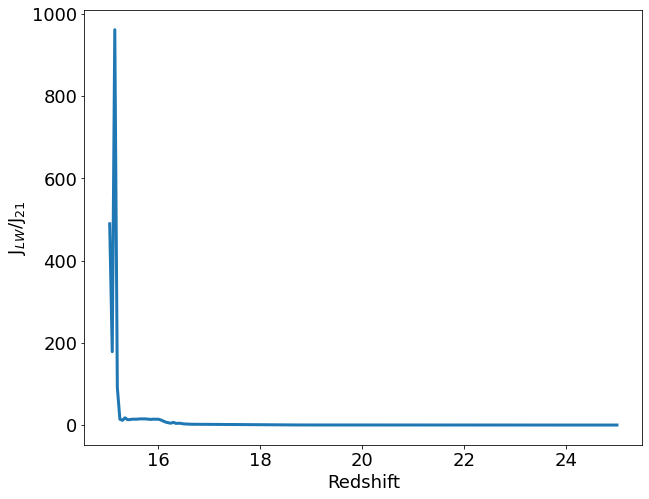

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
#ax.semilogy(allz, JLW*1e21, lw=3)
ax.plot(allz, JLW*1e21, lw=3)
ax.set_xlabel('Redshift')
ax.set_ylabel(r'J$_{LW}$/J$_{21}$')
#ax.set_ylabel(r'log(J$_{LW}$/J$_{21}$)')
plt.show()

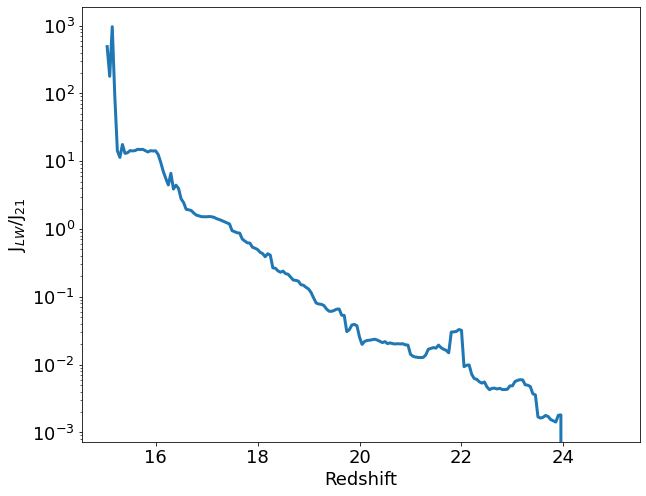

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
#ax.semilogy(allz, JLW*1e21, lw=3)
ax.semilogy(allz, JLW*1e21, lw=3)
ax.set_xlabel('Redshift')
ax.set_ylabel(r'J$_{LW}$/J$_{21}$')
#ax.set_ylabel(r'log(J$_{LW}$/J$_{21}$)')
plt.show()

In [20]:
# Background from Wise & Abel (2005), Wise et al. (2012b)
zz = allz+1
log_LWB = -23.56688 + 4.5213e-1 * zz - 2.679832e-2 * zz**2 + 5.88234e-4 * zz**3 - \
    5.05576e-6 * zz**4
LWB = 10**log_LWB
JLW_total = JLW + LWB

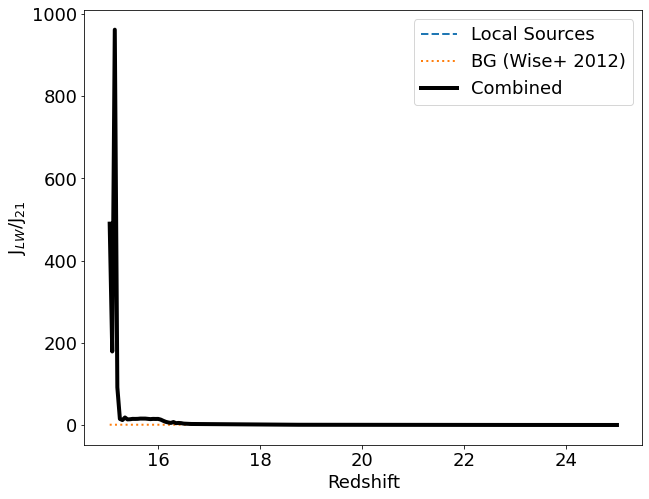

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
#ax.semilogy(allz, JLW*1e21, lw=3)
ax.plot(allz, JLW*1e21, lw=2, ls='--', label='Local Sources')
ax.plot(allz, LWB*1e21, lw=2, ls=':', label='BG (Wise+ 2012)')
ax.plot(allz, JLW_total*1e21, c='k', lw=4, ls='-', label='Combined')
ax.set_xlabel('Redshift')
ax.set_ylabel(r'J$_{LW}$/J$_{21}$')
ax.legend(loc='best')
#ax.set_ylabel(r'log(J$_{LW}$/J$_{21}$)')
plt.show()

# Create Lyman-Werner background table for Grackle
Needs rates, not intensities.  We only provide the H2 dissociation rate and we neglect any ionization and heating.

In [22]:
def k31(J21):
    return 1.42e9 * (J21)

In [23]:
outfile = "LWB-MMHalo.h5"
info_string = "RS-RP-MMHalo-LWB"

rate_names = ["k24", "k25", "k26", "k27", "k28", "k29", "k30", "k31",
              "piHI", "piHeII", "piHeI"]

outdata = dict(z = allz,
               k31 = k31(JLW_total))

rate0 = np.zeros(outdata["z"].size)

fp = h5.File(outfile, "w")

fp['UVBRates/Info'] = np.string_(info_string)
fp['UVBRates/z'] = outdata["z"]

for name in rate_names:
    if name == "z":
        fname = "/UVBRates/%s" % (name)
    elif name.startswith("k"):
        fname = "/UVBRates/Chemistry/%s" % (name)
    else:
        fname = "/UVBRates/Photoheating/%s" % (name)
    if name not in outdata.keys():
        fp[fname] = rate0
    else:
        fp[fname] = outdata[name]

fp.close()